## Preliminaries

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random

# packages for data reader
#! pip install pandas_datareader
#! pip install quandl
from pandas_datareader import data as web # yahoo finance
import quandl # quandl

# packages for plots
#! pip install mpl_finance
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc # candlestick chart


In [ ]:
# folder to store data and plot
raw_data_path = "/content/drive/My Drive/COST Project/Colab notebooks/raw_data/"
plot_path = "/content/drive/My Drive/COST Project/Colab notebooks/plot/"
# set up time period
start = datetime(2015,6,1)
end = datetime(2020,6,1)
duration = "5y"

## Download Data

Download stock data from <a href="https://finance.yahoo.com/recent-quotes/">yahoo finance</a> and future data from <a href="https://www.quandl.com/data/CHRIS/CME_ES1-E-mini-S-P-500-Futures-Continuous-Contract-1-ES1-Front-Month">quandl</a>.

### Single stock: IBM

In [ ]:
ibm = web.DataReader('IBM', 'yahoo', start, end)
ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2015-06-01 to 2020-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1260 non-null   float64
 1   Low        1260 non-null   float64
 2   Open       1260 non-null   float64
 3   Close      1260 non-null   float64
 4   Volume     1260 non-null   float64
 5   Adj Close  1260 non-null   float64
dtypes: float64(6)
memory usage: 68.9 KB


In [ ]:
ibm.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-06-01,171.039993,169.029999,170.210007,170.179993,2985500.0,136.927917
2015-06-02,170.449997,168.429993,169.660004,169.649994,2571400.0,136.501480
2015-06-03,171.559998,169.630005,170.500000,169.919998,2131000.0,136.718750
2015-06-04,170.600006,167.929993,169.529999,168.380005,3079300.0,135.479660
2015-06-05,168.910004,167.199997,168.250000,167.399994,3100500.0,134.691132


In [ ]:
# store in csv
ibm.to_csv(raw_data_path+'equity_ibm_'+duration+'.csv')

### Stock pool: S&P 500

In [ ]:
# Get list of stocks in S&P 500
# There are 2 tables on the Wikipedia page
# we want the first table

payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
stock_df = payload[0]
stock_list = list(stock_df['Symbol'])

In [ ]:
stock_list[:5]

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN']

In [ ]:
# store in csv
valid_list = []
for symbol in stock_list:
  try:
    # get 5 years daily data for each symbol in S&P 500 stock pool
    data = web.DataReader(symbol, 'yahoo', start, end)
    # if there are more than 5% missing data, drop this stock
    if len(data.dropna())/len(data) <= 0.95:
      continue
    # else save data to drive
    data.to_csv(raw_data_path+'equity_'+symbol.lower()+'_'+duration+'.csv')
    valid_list.append(symbol)
    print(f"{symbol.lower()} data downloaded successfully!")
    time.sleep(random.uniform(0.3, 1))
  except:
    continue

#### Adj Close Prices for all stocks

In [ ]:
prices = web.DataReader(stock_list, 'yahoo', start, end)['Adj Close']

/usr/local/lib/python3.6/dist-packages/pandas_datareader/base.py:270: SymbolWarning: Failed to read symbol: 'BRK.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/usr/local/lib/python3.6/dist-packages/pandas_datareader/base.py:270: SymbolWarning: Failed to read symbol: 'BF.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


In [ ]:
prices = prices.dropna(axis=1)
prices.shape
# After drop stocks with missing data, there remains 486 stocks (from 505 to 486)

(1260, 486)

In [ ]:
prices.head(5)

Symbols,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALXN,ALGN,ALLE,ADS,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,...,UHS,UNM,VFC,VLO,VAR,VTR,VRSN,VRSK,VZ,VRTX,V,VNO,VMC,WRB,WAB,WMT,WBA,DIS,WM,WAT,WEC,WFC,WELL,WST,WDC,WU,WY,WHR,WMB,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-06-01,138.025436,44.218430,53.367821,60.340000,87.960396,24.553200,79.870003,2.25,151.147644,11.152272,27.620338,38.991932,118.725395,75.230003,60.609211,54.747662,80.425980,164.779999,61.740002,59.222103,282.139679,26.195061,60.783951,549.210022,533.989990,39.121964,430.920013,8.516801,34.084499,42.031494,47.102600,73.306030,51.598885,85.013969,47.813484,108.959343,103.885170,51.790142,137.054474,54.354298,...,128.758469,30.438017,57.739933,48.323986,75.334480,58.633022,63.259998,72.807549,39.300667,126.800003,66.648201,66.709702,85.833313,29.576105,96.938698,65.828247,76.173103,103.416199,44.097370,133.820007,40.202904,47.192017,55.342346,53.091198,80.835320,18.189901,26.247416,161.404968,37.016937,115.751320,87.981873,28.865599,25.497324,43.529865,34.241154,59.004112,110.339996,110.333046,26.133894,48.092304
2015-06-02,138.112244,44.218430,53.120647,59.660000,88.088417,24.678867,79.820000,2.30,153.158707,10.996924,27.691500,39.172981,119.289047,75.459999,60.269920,55.488602,79.841682,163.910004,62.369999,59.556206,283.165131,25.823833,60.974697,553.950012,539.179993,38.686440,430.989990,8.516801,33.576023,41.650951,46.396194,73.785683,52.478199,84.941795,47.297810,110.262405,103.169731,52.118057,136.539520,54.791409,...,127.087944,30.951557,58.068905,48.102020,75.816772,58.248775,62.310001,72.095009,39.236790,124.800003,66.580704,66.161766,86.437057,29.840769,96.831917,65.652069,76.483177,103.220490,43.937782,134.089996,39.454563,47.309910,54.867802,53.285316,80.685539,18.330780,26.182804,162.501343,36.959232,115.726997,89.566238,28.297947,25.541822,43.034485,34.325356,58.742645,114.089996,109.746628,27.888340,47.899101
2015-06-03,139.049881,44.146141,53.431610,62.049999,88.682808,25.094530,80.129997,2.28,154.312134,10.751640,27.802698,39.163452,119.442032,76.019997,60.398300,56.211250,78.604370,161.529999,63.400002,59.957134,283.905762,25.435535,61.510612,555.289978,540.309998,38.472485,436.589996,8.516801,33.313313,41.032566,45.731842,74.348412,53.735649,83.615570,46.754990,111.381836,103.077980,52.195206,137.141739,55.000465,...,126.871758,31.343235,58.504753,47.485424,76.755058,57.267784,62.980000,73.411217,39.188885,126.919998,66.493904,65.600632,85.421257,30.261824,96.948425,65.969200,76.031357,103.611938,44.004807,134.669998,38.847549,47.924656,53.903164,54.624729,81.675911,18.421940,25.954634,163.381958,35.999905,115.848595,91.347542,27.823486,25.653072,42.665207,34.577957,59.840771,114.070000,109.496651,28.253847,47.870106
2015-06-04,137.478470,43.983513,53.758537,63.310001,87.722641,24.833534,78.750000,2.33,154.381165,10.645350,27.624786,38.629833,117.501518,75.139999,60.077328,56.046589,78.733246,159.059998,62.790001,59.021648,280.288086,25.200850,60.902039,551.690002,536.700012,38.113358,430.779999,8.516801,33.126877,40.119244,45.656147,73.204575,53.295975,85.410957,46.791168,109.606506,102.261681,51.404373,137.979599,54.116737,...,125.024345,31.090822,58.003113,46.761967,76.018463,57.373844,62.720001,72.975784,38.406387,126.940002,65.780273,65.686440,84.922951,29.870842,95.929123,65.317345,75.526375,102.801094,43.495506,133.860001,38.481705,47.276230,54.159882,53.411491,79.395576,18.140182,25.824253,162.294205,34.997311,114.730194,97.962532,27.764181,25.163591,42.521107,34.072754,59.167515,113.470001,108.698746,28.135061,47.242149
2015-06-05,136.375854,43.775707,53.742588,63.820000,87.237999,24.910866,78.860001,2.33,155.159943,10.751640,27.491360,38.410683,117.219719,75.239998,60.214886,55.918526,77.315491,160.259995,62.910000,59.088459,280.506500,24.872293,60.384300,549.530029,533.

In [ ]:
# store in csv
prices.to_csv(raw_data_path+'equity_sp500_adjclose_'+duration+'.csv')

### Single future: S&P 500 continuous future

E-mini S&P 500 Futures, Continuous Contract #1 (ES1) (Front Month)

https://www.quandl.com/data/CHRIS/CME_ES1-E-mini-S-P-500-Futures-Continuous-Contract-1-ES1-Front-Month


In [ ]:
quandl.ApiConfig.api_key = "LURRP3KKsaeY3pueh2Gz"
CME_ES1 = quandl.get("CHRIS/CME_ES1")

In [ ]:
es1 = CME_ES1[(CME_ES1.index >= start) & (CME_ES1.index <= end)].copy()
es1.to_csv(raw_data_path+'future_es1_'+duration+'.csv')

In [ ]:
es1.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2015-06-01,2107.00,2117.75,2100.25,2111.50,3.25,2109.25,1337694.0,2766529.0
2015-06-02,2111.00,2116.00,2094.00,2106.75,2.50,2106.75,1442673.0,2763714.0
2015-06-03,2107.00,2120.75,2106.75,2116.25,9.25,2116.00,1310989.0,2760870.0
2015-06-04,2116.25,2116.50,2091.25,2098.75,17.00,2099.00,1716475.0,2751605.0
2015-06-05,2098.75,2102.75,2083.50,2091.50,6.75,2092.25,1459933.0,2785151.0


### Future pool: need premium

Need **Premium** to access data from https://www.quandl.com/databases/SCF/data.

Quandl Code Format: Data in the `SCF/PRICES` table can be queried for specific contract data. Each contract is represented by a `quandl_code`. Quandl codes from the Stevens Continuous Futures data feed follow the format: `{exchange}_{symbol}{depth}_{method}`.

We need continous futures data (only front-month, only roll methodology OR (backwards ratio open interest switch), that means our tickers end in 1_OR).

## Descriptive Analysis

### Stock pool
Ordinary returns and logarithmic returns are only equal when they are zero, but they are approximately equal when they are small.
There are several advantages of log return, both theoretic and algorithmic.
And it is defined as follows:
$$
r_{i}=\log \left(\frac{S\left(t_{i}\right)}{S\left(t_{i-1}\right)}\right)
$$

In [ ]:
# compute daily log return of adj close prices
rets = np.log(prices/prices.shift())

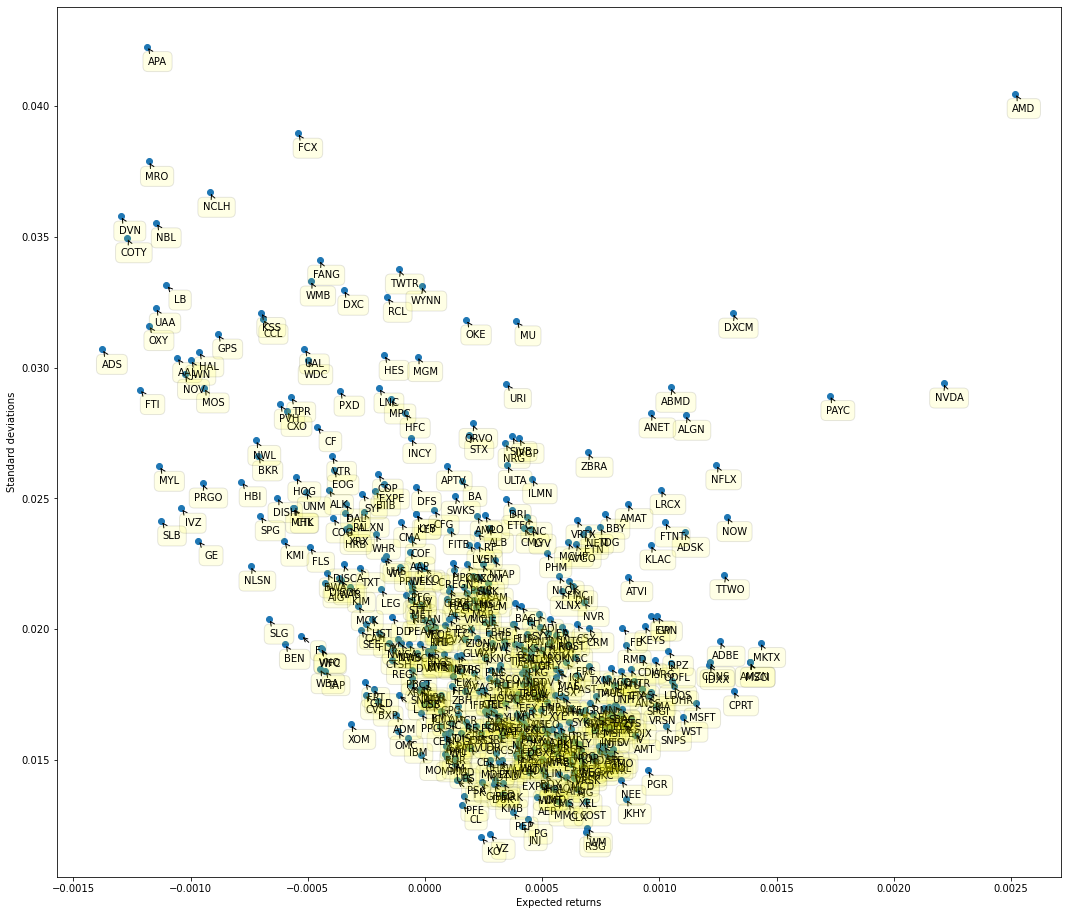

In [ ]:
# mean and std
# we find mean and standard deviation of log returns cluster at (0.0005, 0.015)
plt.figure(figsize=(18,16))
plt.scatter(rets.mean(), rets.std())
plt.xlabel('Expected returns')
plt.ylabel('Standard deviations')
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.1),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.savefig(plot_path+'equity_sp500_adjclose_'+duration+'_mn_std.png')
plt.show()

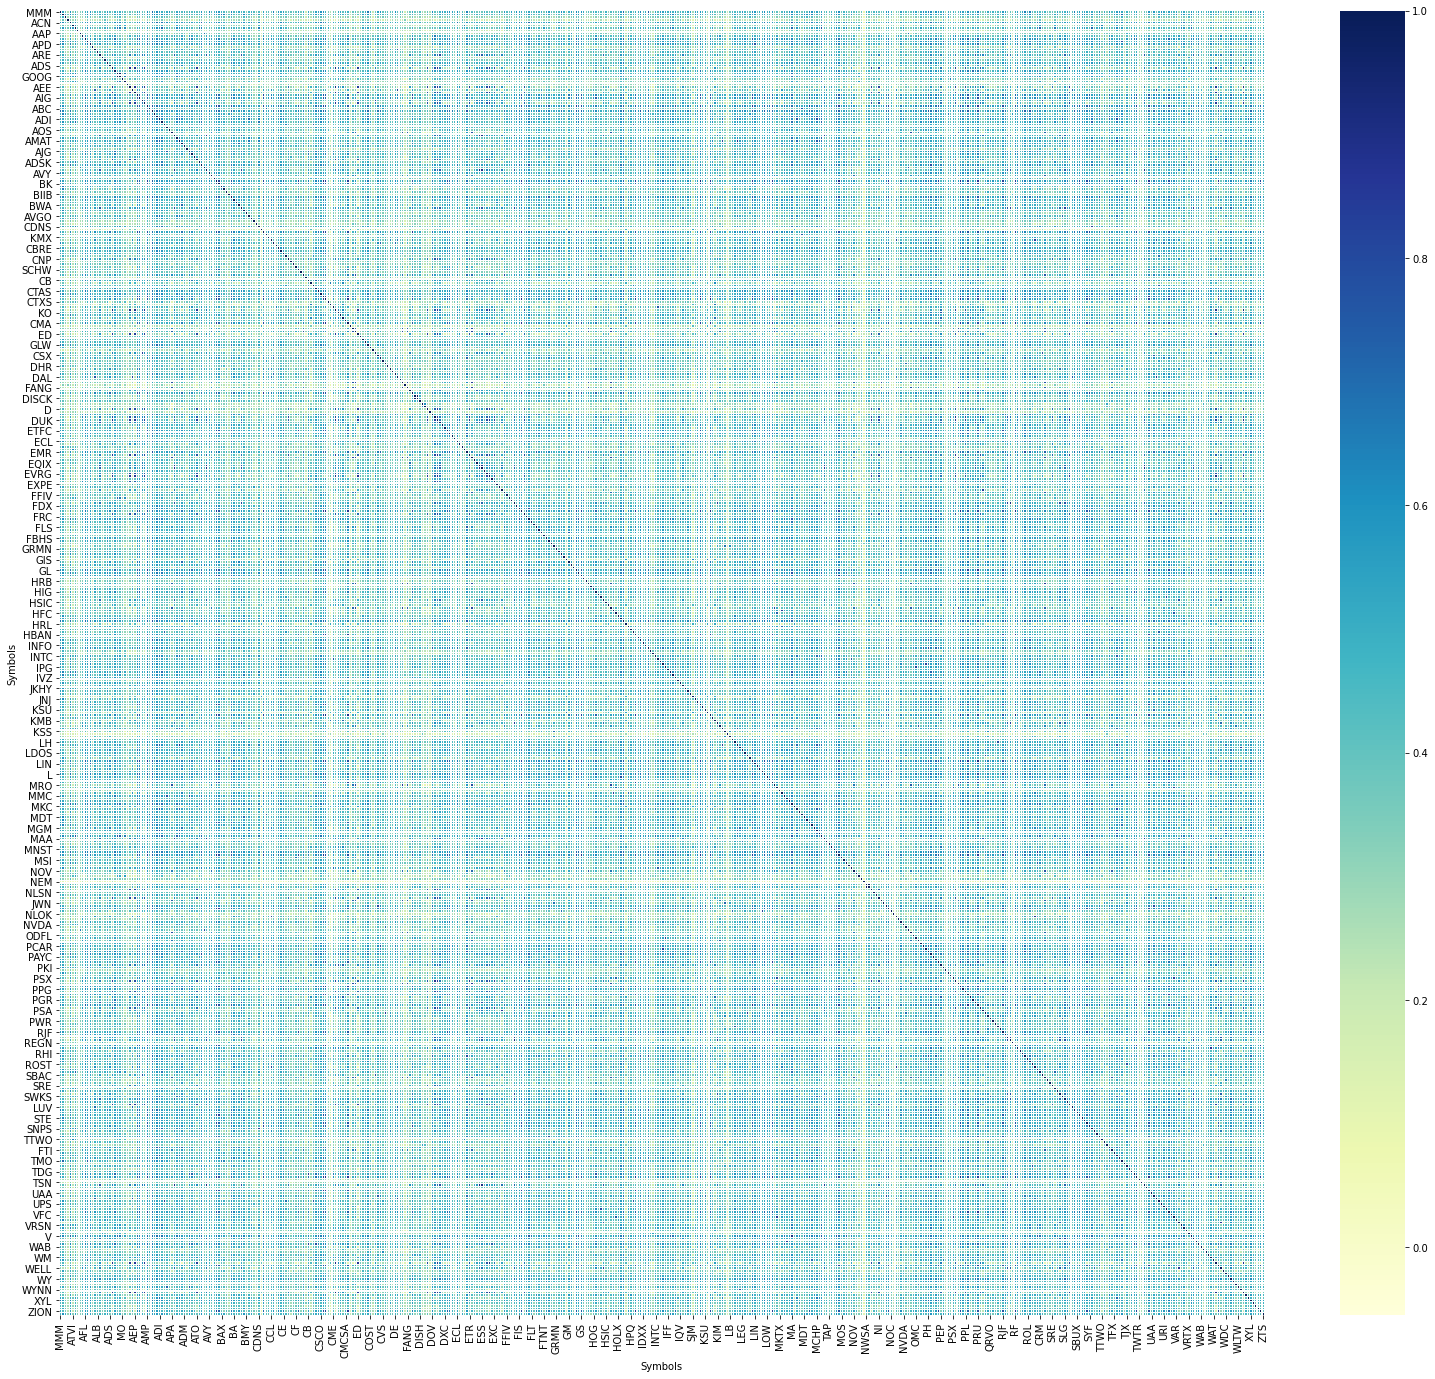

In [ ]:
# correlation matrix
# there are several "white lines" in plots, which incidates stocks low correlated with others
corrmat = rets.corr() 
  
f, ax = plt.subplots(figsize =(27, 24)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 
plt.savefig(plot_path+'equity_sp500_adjclose_'+duration+'_corr.png')
plt.show()

### S&P 500 continuous future

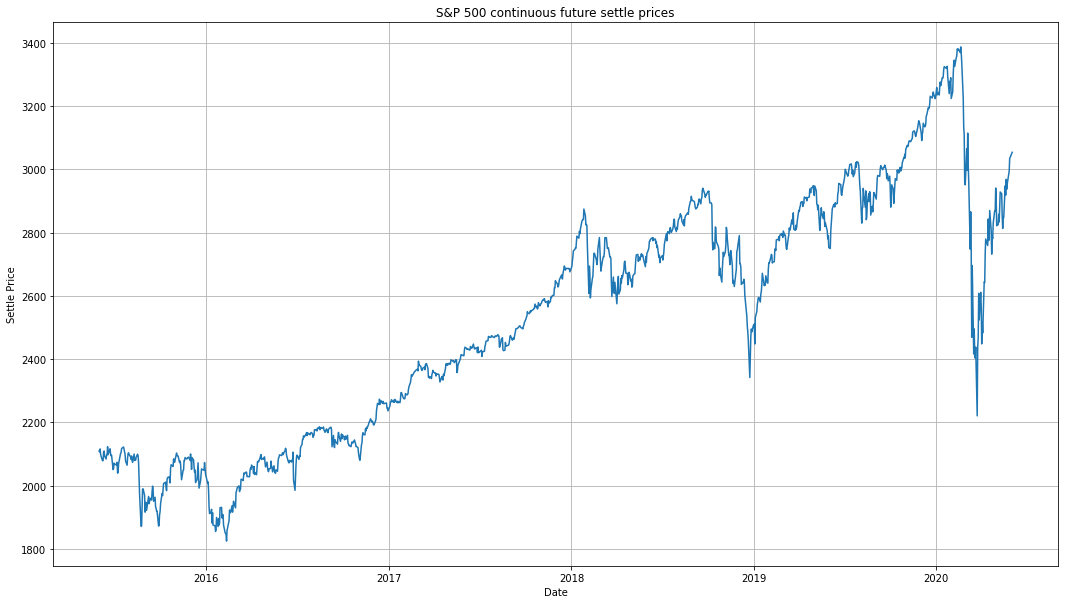

In [31]:
# plot 1: settle price
fig = plt.figure(figsize=(18,10))
plt.title("S&P 500 continuous future settle prices")
plt.ylabel("Settle Price")
plt.xlabel("Date")
plt.grid(True)
plt.plot(es1["Settle"])
#plt.legend()
plt.savefig(plot_path + 'future_es1_settle_'+duration+'.png')
plt.show()

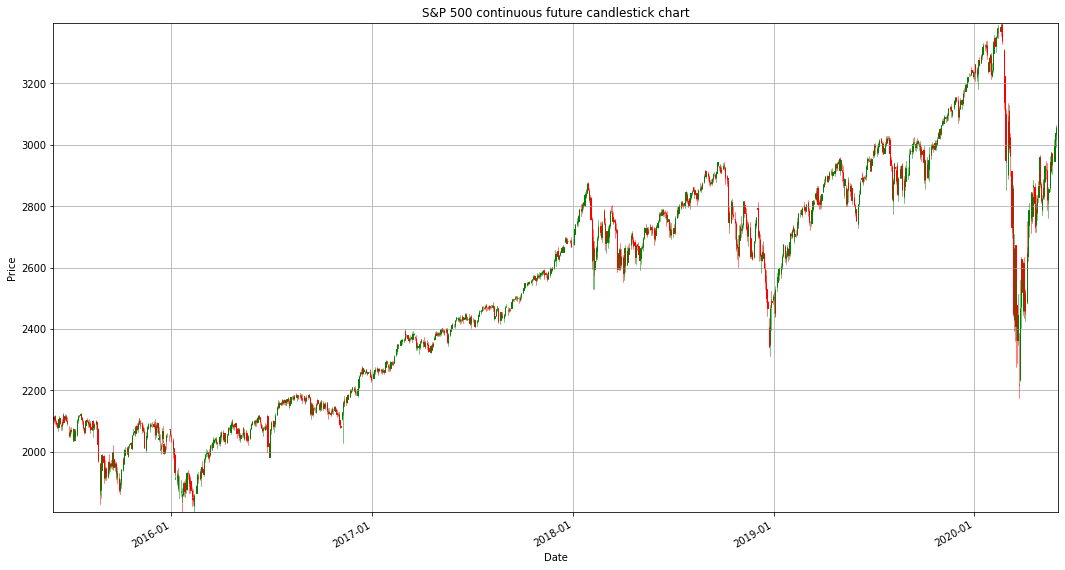

In [32]:
### plot 2: candlestick chart

# Convert 'Timestamp' to 'float': candlestick_ohlc needs time to be in float days format
es1['date'] = [mdates.date2num(d) for d in es1.index]

# Re-arrange data so that each row contains values of a day: 'date','open','high','low','close'
quotes = [tuple(x) for x in es1[['date','Open','High','Low','Last']].values]

# Plot candlestick
fig, ax = plt.subplots(figsize=(18,10))
candlestick_ohlc(ax, quotes, width=0.5, colorup='g', colordown='r');
# Customize graph
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('S&P 500 continuous future candlestick chart')
plt.grid(True)
# Format time
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.autoscale(tight=True)
plt.savefig(plot_path + 'future_es1_candle_'+duration+'.png')
plt.show()

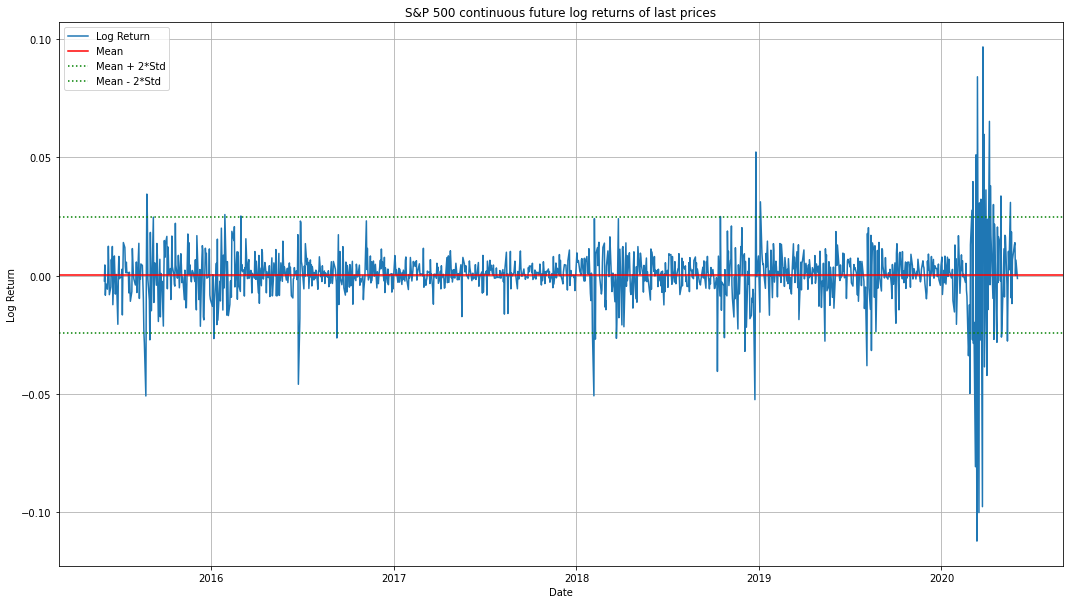

In [40]:
# log return of last prices
rets = np.log(es1['Last']/es1['Last'].shift())

# plot 3: log return
fig = plt.figure(figsize=(18,10))
plt.title("S&P 500 continuous future log returns of last prices")
plt.ylabel("Log Return")
plt.xlabel("Date")
plt.grid(True)
plt.plot(rets, label='Log Return')
plt.axhline(y=rets.mean(), color='r', linestyle='-', label='Mean')
plt.axhline(y=rets.mean()+ 2*rets.std(), color='g', linestyle=':', label='Mean + 2*Std')
plt.axhline(y=rets.mean()- 2*rets.std(), color='g', linestyle=':', label='Mean - 2*Std')
plt.legend()
plt.savefig(plot_path + 'future_es1_ret_'+duration+'.png')
plt.show()

## Simulation Engine

### GBM

#### Estimating Drift and Volatility

Historical data has been used in order to find estimates of the drift $\hat{\mu}$ and volatility $\hat{\sigma}$.

Here we simply assume that drift and volatility are **constant** throughout the time period. It’s not reasonable, but we start from this toy engine.

Under the assumption of GBM, The observations $\{r_1, ..., r_n\}$ are assumed to be independent, normally distributed random variables. Therefore the expectation and variance can be expressed as:

$$
E\left[r_{i}\right]=\left(\mu-\frac{1}{2} \sigma^{2}\right) \Delta t, \quad \operatorname{Var}\left[r_{i}\right]=\sigma^{2} \Delta t
$$

The sample variance is given by:

$$
\frac{1}{n-1} \sum_{i=1}^{n}\left(r_{i}-\hat{\mu}\right)^{2}
$$

We can therefore get the estimation of $\mu$ and $\sigma$.

Reference:

    @misc{liden2018stock,
      title={Stock Price Predictions using a Geometric Brownian Motion},
      author={Lid{\'e}n, Joel},
      year={2018}
    }
    

Also, for an arbitrary initial value $S_0$ the SDE of GBM has the analytic solution:

$$
S_{t}=S_{0} \exp \left(\left(\mu-\frac{\sigma^{2}}{2}\right)t+\sigma W(t)\right)
$$


In [53]:
def GBM_engine(price_series, dt=1):
  """
  simulate GBM process according to historical data 'price_series' and time grid 'dt'
  """
  # log return
  rets = np.log(price_series/price_series.shift())
  # estimate sig and mu
  sig = rets.std()/dt
  mu = rets.mean()/dt + sig**2/2

  # GBM process 's'
  s = np.zeros_like(price_series)
  s[0] = price_series[0]

  for i in np.arange(1, len(price_series)):
      z = np.random.randn()
      s[i] = s[i-1] * np.exp((mu - sig**2/2)*dt + sig*np.sqrt(dt)*z)
    
  return s

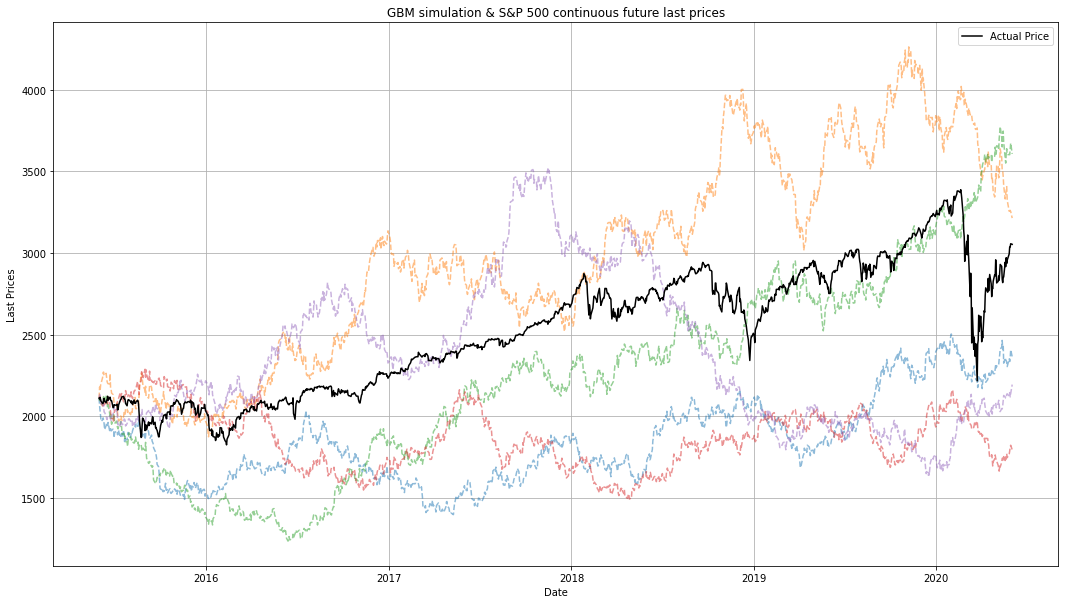

In [75]:
# show 5 GBM processes, comparing with actual last prices
np.random.seed = 123

fig = plt.figure(figsize=(18,10))
plt.title("GBM simulation & S&P 500 continuous future last prices")
plt.ylabel("Last Prices")
plt.xlabel("Date")
plt.grid(True)
for i in range(5):
  plt.plot(es1.index, GBM_engine(es1['Last']), ls='--', alpha=0.5)
plt.plot(es1['Last'], ls='-', label='Actual Price', color='black')
plt.legend()
plt.savefig(plot_path + 'future_es1_gbm_'+duration+'.png')
plt.show()